# EfficientNet_B0 Transfer Learning Experimentation: Improving Image Recognition with Pre-trained Weights

In [1]:
# Import libraries
import torch
import torchvision 
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary

import data_setup
import engine 

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


/Users/vadimsuharev/miniconda3/envs/cnn_transfer_learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup device agnostic code
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Import libraries
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
# Setup directories
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [5]:
# Set of pretrained models for EfficientNet
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
weights, model 


(EfficientNet_B0_Weights.IMAGENET1K_V1,
 EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): SiLU(inplace=True)
           )
           (1): SqueezeExcitation(
             (avgpool): AdaptiveAvgPool2d(output_size=1)
             (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (activation): SiLU(inplace=True)
             (scale_activa

In [6]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir, 
    transform=auto_transforms,
    batch_size=32)

In [8]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [9]:
# Print torchinfo 
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']) 

/Users/vadimsuharev/miniconda3/envs/cnn_transfer_learning/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/vadimsuharev/miniconda3/envs/cnn_transfer_learning/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [10]:
# Freezing the base model
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
# Print torchinfo 
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [12]:
# Update the classifier to have 3 outputs
model.classifier = nn.Sequential(
    nn.Dropout(p=0.1, inplace=True),
    nn.Linear(in_features=1280, out_features=3)).to(device)

In [13]:
model.classifier

Sequential(
  (0): Dropout(p=0.1, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

#### Train Model

In [14]:
# Define loss and optimizer
import torch
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [15]:
# Setup training and save the results 
results = engine.train(model=model,
                       train_dataloader=train_dataloader, 
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=4,
                       device=device)

 25%|██▌       | 1/4 [02:06<06:19, 126.57s/it]

Epoch: 1 | train_loss: 0.7144 | train_acc: 0.6667 | test_loss: 0.4278 | test_acc: 0.8210


 50%|█████     | 2/4 [04:12<04:12, 126.36s/it]

Epoch: 2 | train_loss: 0.3804 | train_acc: 0.8542 | test_loss: 0.2502 | test_acc: 0.9062


 75%|███████▌  | 3/4 [06:13<02:03, 123.94s/it]

Epoch: 3 | train_loss: 0.3325 | train_acc: 0.8646 | test_loss: 0.3248 | test_acc: 0.8676


100%|██████████| 4/4 [08:12<00:00, 123.24s/it]

Epoch: 4 | train_loss: 0.3418 | train_acc: 0.8958 | test_loss: 0.2341 | test_acc: 0.9222


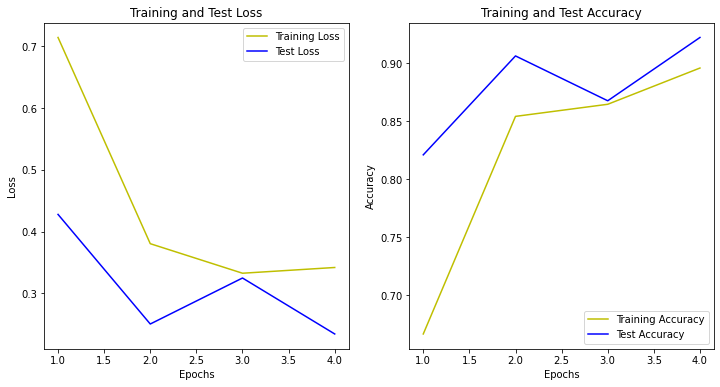

In [16]:
# get the train and test loss curve
train_loss = results['train_loss']
test_loss = results['test_loss']
train_acc = results['train_acc']
test_acc = results['test_acc']

# create a list of epochs
epochs = range(1, len(train_loss) + 1)

# set figure size
plt.figure(figsize=(12, 6))

# plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'y', label='Training Loss')
plt.plot(epochs, test_loss, 'b', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'y', label='Training Accuracy')
plt.plot(epochs, test_acc, 'b', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# display the plots
plt.show()


In [17]:
# Save the model to a file
torch.save(model.state_dict(), 'fine_tuned_model_weights.pth')

In [18]:
# # Model loading
# model.load_state_dict(torch.load('fine_tuned_model_weights.pth'))